# Imports

In [1]:
! pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import io
import datetime
import string
import re
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,
                                     BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from google.colab import files
from tensorflow.keras.callbacks import Callback
from tensorboard.plugins import projector
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.losses import BinaryCrossentropy
from transformers import AutoTokenizer,create_optimizer,TFAutoModel

In [3]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-23 15:25:52--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-23 15:25:52 (70.5 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [4]:
from helper_functions import (make_confusion_matrix, plot_loss_curves, calculate_results, plot_class_accuracy,
                              plot_prediction_confidence_histogram, create_tensorboard_callback)

# Data Loading

In [5]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c quora-question-pairs
! unzip "/content/quora-question-pairs.zip" -d "/content/dataset/"
! unzip "/content/dataset/train.csv.zip" -d "/content/dataset/"

 97% 301M/309M [00:02<00:00, 126MB/s]
100% 309M/309M [00:02<00:00, 133MB/s]
Archive:  /content/quora-question-pairs.zip
  inflating: /content/dataset/sample_submission.csv.zip  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/test.csv.zip  
  inflating: /content/dataset/train.csv.zip  
Archive:  /content/dataset/train.csv.zip
  inflating: /content/dataset/train.csv  


# Data Loading

In [6]:
df = pd.read_csv("/content/dataset/train.csv")
df = df.sample(100000)

In [7]:
df.drop(columns=['qid1', 'qid2', 'id'], inplace=True)

In [8]:
df.head(5)

,question1,question2,is_duplicate
27627,"What if all of The Bible is true, except Adam ...",What is the reason behind Indians not celebrat...,0
259296,Which one is your favorite movie?,What are some of your favorite movies?,1
69998,What are examples of non-sexist gender roles?,Is non-hierarchical gender possible?,0
22252,Why is Twenty One Pilots so popular?,Do you think that Twenty One Pilots is great?,0
347942,How can I get rid of dark fingertips?,Consumer v/s customer with examples of banking...,0


In [9]:
df.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df['is_duplicate'].value_counts()

0    63226
1    36774
Name: is_duplicate, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 27627 to 386793
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     100000 non-null  object
 1   question2     100000 non-null  object
 2   is_duplicate  100000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.1+ MB


In [14]:
contractions = {"ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"}

In [15]:
def preprocess(text):
    text = str(text).lower().strip()
    # Replace certain special characters with their string equivalents
    text = text.replace('%', ' percent')
    text = text.replace('$', ' dollar ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    # The pattern '[math]' appears around 900 times in the whole dataset.
    text = text.replace('[math]', '')
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    text = text.replace(',000,000,000 ', 'b ')
    text = text.replace(',000,000 ', 'm ')
    text = text.replace(',000 ', 'k ')
    text = re.sub(r'([0-9]+)000000000', r'\1b', text)
    text = re.sub(r'([0-9]+)000000', r'\1m', text)
    text = re.sub(r'([0-9]+)000', r'\1k', text)

    text_decontracted = []
    for word in text.split():
        if word in contractions:
            word = contractions[word]
        text_decontracted.append(word)

    text = ' '.join(text_decontracted)
    text = text.replace("'ve", " have")
    text = text.replace("n't", " not")
    text = text.replace("'re", " are")
    text = text.replace("'ll", " will")
    # Removing HTML tags
    text = BeautifulSoup(text)
    text = text.get_text()
    # Remove punctuations
    pattern = re.compile('\W')
    text = re.sub(pattern, ' ', text).strip()
    # strip spaces
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [16]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already was not done'

In [17]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

<ipython-input-15-92524b1413b6>:31: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text)


In [18]:
new_df = df.copy()

In [19]:
df['q1_num_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_num_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

# Tokenization and Embeddings

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['is_duplicate'], axis=1), df['is_duplicate'], test_size=0.20)

In [21]:
class_labels = ['not_same', 'same']
print("Classes:", class_labels)

Classes: ['not_same', 'same']


In [22]:
train_q1_sentences = X_train['question1']
train_q2_sentences = X_train['question2']
train_q1_num_words = X_train['q1_num_words']
train_q2_num_words = X_train['q2_num_words']

test_q1_sentences = X_test['question1']
test_q2_sentences = X_test['question2']
test_q1_num_words = X_test['q1_num_words']
test_q2_num_words = X_test['q2_num_words']

In [23]:
print("Number of training samples:", len(train_q1_sentences), len(y_train))
print("Number of test samples:", len(test_q1_sentences), len(y_test))

Number of training samples: 80000 80000
Number of test samples: 20000 20000


In [24]:
q1_length = [len(sentence.split()) for sentence in df['question1']]
avg_q1_length  = np.mean(q1_length)

q2_length = [len(sentence.split()) for sentence in df['question2']]
avg_q2_length  = np.mean(q2_length)

print("Avg Question1 Length", avg_q1_length)
print("Avg Question2 Length", avg_q2_length)

Avg Question1 Length 11.12859
Avg Question2 Length 11.4009


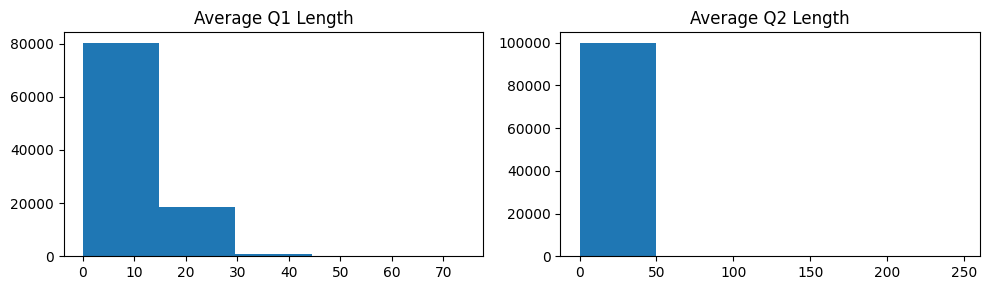

In [25]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title("Average Q1 Length")
plt.hist(q1_length, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average Q2 Length")
plt.hist(q2_length, bins=5)

plt.tight_layout()
plt.show()

In [26]:
output_q1_length = int(np.percentile(q1_length, 95))
output_q2_length = int(np.percentile(q2_length, 95))
print("Output Question1 Length:", output_q1_length)
print("Output Question2 Length:", output_q2_length)

Output Question1 Length: 22
Output Question2 Length: 24


In [27]:
max_tokens = 30000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                      output_mode = 'int',
                                      standardize = 'lower_and_strip_punctuation',
                                      output_sequence_length = 24)

vectorize_layer.adapt(train_q1_sentences)

In [28]:
random_sentence = random.choice(train_q1_sentences)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: in which countries are kindle devices bought and used the most
Length of sentence: 11
Vectorized_Form: tf.Tensor(
[[   9   25  278   12 3535 1285 2853   13  126    2   54    0    0    0
     0    0    0    0    0    0    0    0    0    0]], shape=(1, 24), dtype=int64)


In [29]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 30000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'the', 'what', 'is']
The Least Most 5 common words in vocalbuary: ['collingwood', 'collier', 'colliding', 'collides', 'collided']


In [30]:
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 30000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 24,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 30000}

In [31]:
token_embed = Embedding(input_dim = 30000,
                        output_dim = 128,
                        name = "Embeddings")

In [32]:
target_sentence = random.choice(train_q1_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
how can i increase my sprinting speed

Sentence after vectorization (before embedding):
[[    5    14     6   208    20 20498   422     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.03296255 -0.03155426  0.01992008 ... -0.03315452 -0.02021252
    0.01676626]
  [-0.02433305 -0.02386619  0.00870984 ... -0.02788067  0.0035594
   -0.04365107]
  [ 0.03629012 -0.0184898   0.00872308 ...  0.04123083  0.00812385
    0.04175043]
  ...
  [ 0.03506703  0.03503665  0.01200104 ... -0.00041367 -0.00370632
    0.02543682]
  [ 0.03506703  0.03503665  0.01200104 ... -0.00041367 -0.00370632
    0.02543682]
  [ 0.03506703  0.03503665  0.01200104 ... -0.00041367 -0.00370632
    0.02543682]]]

Embedded sentence shape: (1, 24, 128)


# Data Loading

In [33]:
label = df['is_duplicate'].value_counts().index
values = df['is_duplicate'].value_counts().values
total_samples = 100000
weights = {}
for label, value in zip(label, values):
  weights[label] = total_samples / value

print("Weights:", weights)

Weights: {0: 1.5816278113434346, 1: 2.719312557785392}


In [34]:
train_q1_num_words = tf.one_hot(train_q1_num_words, depth=24)
train_q2_num_words = tf.one_hot(train_q2_num_words, depth=24)

test_q1_num_words = tf.one_hot(test_q1_num_words, depth=24)
test_q2_num_words = tf.one_hot(test_q2_num_words, depth=24)

In [35]:
train_q1_sentences = tf.data.Dataset.from_tensor_slices(train_q1_sentences)
train_q2_sentences = tf.data.Dataset.from_tensor_slices(train_q2_sentences)
train_q1_num_words = tf.data.Dataset.from_tensor_slices(train_q1_num_words)
train_q2_num_words = tf.data.Dataset.from_tensor_slices(train_q2_num_words)
train_label = tf.data.Dataset.from_tensor_slices(y_train)

test_q1_sentences = tf.data.Dataset.from_tensor_slices(test_q1_sentences)
test_q2_sentences = tf.data.Dataset.from_tensor_slices(test_q2_sentences)
test_q1_num_words = tf.data.Dataset.from_tensor_slices(test_q1_num_words)
test_q2_num_words = tf.data.Dataset.from_tensor_slices(test_q2_num_words)
test_label = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip(({'question1': train_q1_sentences, 'question1_len': train_q1_num_words,
                                      'question2': train_q2_sentences, 'question2_len': train_q2_num_words }, train_label))
test_dataset = tf.data.Dataset.zip(({'question1': test_q1_sentences, 'question1_len': test_q1_num_words,
                                      'question2': test_q2_sentences, 'question2_len': test_q2_num_words }, test_label))

In [36]:
for inputs, outputs in train_dataset.take(1):
  question1, question1_len, question2, question2_len  = inputs['question1'], inputs['question1_len'], inputs['question2'], inputs['question2_len']
  print("Question 1:", question1)
  print("Question 1 Length:", question1_len)
  print("Question 2:", question2)
  print("Question 2 Length:", question2_len)
  print("Label:", outputs)

Question 1: tf.Tensor(b'can guys wear panties', shape=(), dtype=string)
Question 1 Length: tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(24,), dtype=float32)
Question 2: tf.Tensor(b'is it ok for a guy to wear panties', shape=(), dtype=string)
Question 2 Length: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(24,), dtype=float32)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [37]:
train_dataset = (
    train_dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [38]:
test_dataset = (
     test_dataset
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

# Tensorboard

In [39]:
# Directory for tensorboard callback
os.mkdir("logs")

In [40]:
def create_tensorboard_callback(model_name):
    log_dir = os.path.join("logs", model_name + "_" + dt.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    return tensorboard_callback

# Shared Model

In [41]:
question1_input_layer = Input(shape=(1,), dtype=tf.string, name='question1')
question2_input_layer = Input(shape=(1,), dtype=tf.string, name='question2')

text_vectors = vectorize_layer(question1_input_layer)
q1_embedding = token_embed(text_vectors)
text_vectors = vectorize_layer(question2_input_layer)
q2_embedding = token_embed(text_vectors)

shared_lstm = Bidirectional(LSTM(64))
q1_lstm = shared_lstm(q1_embedding)
q2_lstm = shared_lstm(q2_embedding)

shared_dropout = Dropout(0.6)
q1_lstm = shared_dropout(q1_lstm)
q2_lstm = shared_dropout(q2_lstm)

# shared_dense = Dense(16, activation='relu')
# q1_dense = shared_dense(q1_lstm)
# q2_dense = shared_dense(q2_lstm)

shared_batchnorm = BatchNormalization()
q1_output = shared_batchnorm(q1_lstm)
q2_output = shared_batchnorm(q2_lstm)

q1_numwords_input_layer = Input(shape=(24,), dtype=tf.int32, name="question1_len")
q2_numwords_input_layer = Input(shape=(24,), dtype=tf.int32, name="question2_len")

shared_dense = Dense(16, activation='relu')
q1_len_dense = shared_dense(q1_numwords_input_layer)
q2_len_dense = shared_dense(q2_numwords_input_layer)

q1 = Concatenate()([q1_output, q1_len_dense])
q2 = Concatenate()([q2_output, q2_len_dense])

q = Concatenate()([q1, q2])
q = BatchNormalization()(q)
output_layer = Dense(1, activation="sigmoid")(q)

shared_model = Model(inputs={'question1': question1_input_layer, 'question1_len': q1_numwords_input_layer,
                      'question2': question2_input_layer, 'question2_len': q2_numwords_input_layer},
                    outputs=output_layer)

shared_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question1 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 question2 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 24)                   0         ['question1[0][0]',           
 ctorization)                                                        'question2[0][0]']           
                                                                                                  
 Embeddings (Embedding)      (None, 24, 128)              3840000   ['text_vectorization[0][0]

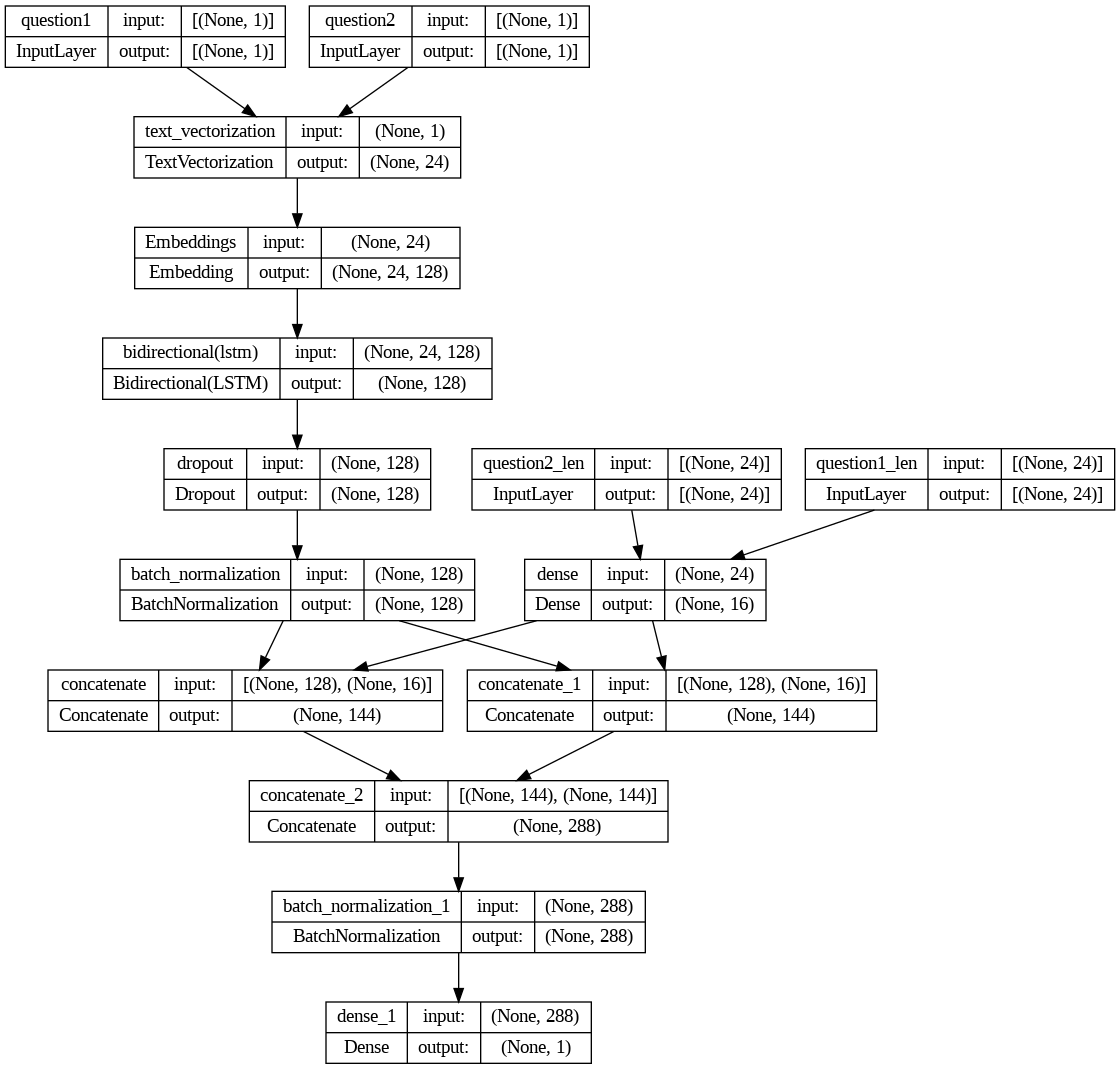

In [42]:
plot_model(shared_model, show_shapes=True)

In [43]:
from tensorflow.keras.metrics import BinaryAccuracy, Recall

In [44]:
shared_model.compile(loss=BinaryCrossentropy(),
                      optimizer=Adam(),
                      metrics=[Recall(name='recall')])

In [45]:
history = shared_model.fit(train_dataset,
                          validation_data = test_dataset,
                          callbacks = create_tensorboard_callback("Shared_model"),
                          class_weight = weights,
                          epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 78s 51ms/step - loss: 1.1902 - recall: 0.6966 - val_loss: 0.5821 - val_recall: 0.8168
Epoch 2/5
1250/1250 [==============================] - 26s 21ms/step - loss: 0.9612 - recall: 0.7919 - val_loss: 0.5689 - val_recall: 0.7588
Epoch 3/5
1250/1250 [==============================] - 24s 19ms/step - loss: 0.6896 - recall: 0.8795 - val_loss: 0.7068 - val_recall: 0.7715
Epoch 4/5
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4758 - recall: 0.9290 - val_loss: 0.8997 - val_recall: 0.7571
Epoch 5/5
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4001 - recall: 0.9395 - val_loss: 1.0135 - val_recall: 0.7140


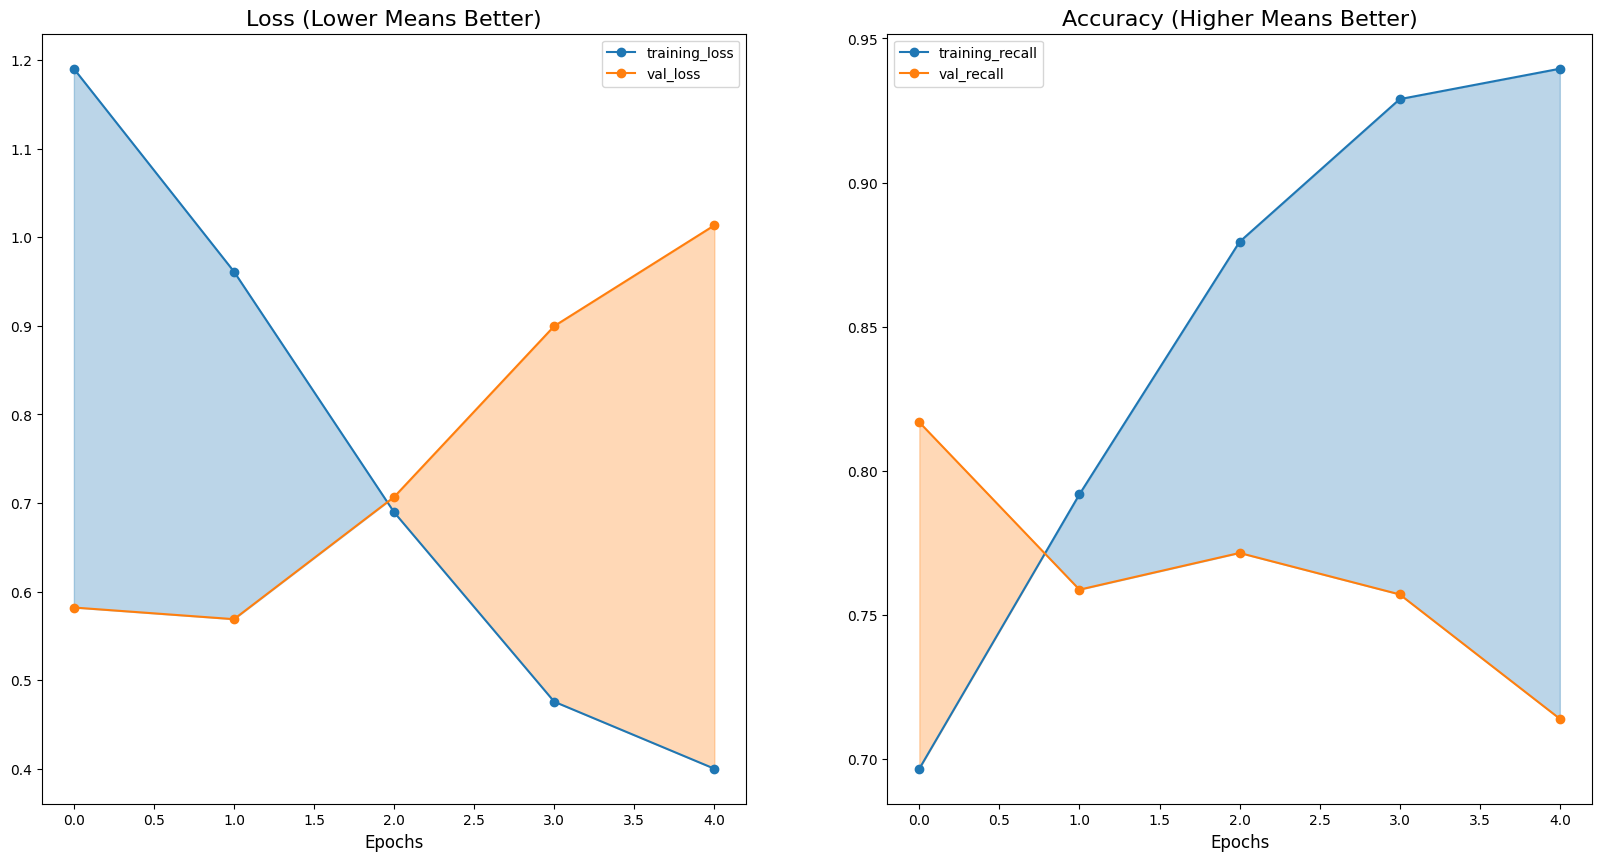

In [48]:
plot_loss_curves(history)

# Model Evaluation

In [50]:
model_pred_probs = shared_model.predict(test_dataset, verbose=1)
model_pred_probs

313/313 [==============================] - 4s 6ms/step


array([[9.8711604e-01],
       [3.9135791e-02],
       [9.6352613e-01],
       ...,
       [5.6532520e-01],
       [1.6598236e-02],
       [2.2285390e-06]], dtype=float32)

In [51]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [52]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

In [53]:
model_results = calculate_results(y_true = true_value,
                                    y_pred = predicted_value)
model_results

{'accuracy': 70.60499999999999,
 'precision': 0.7257376930351618,
 'recall': 0.70605,
 'f1': 0.7108404539087451}

Confusion Matrix


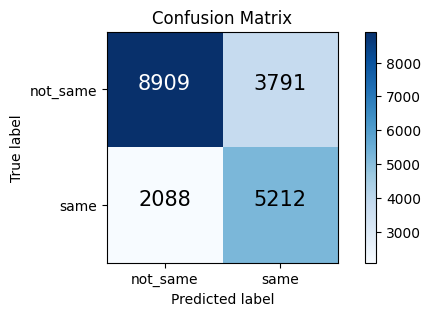

In [54]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [55]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.70      0.75     12700
           1       0.58      0.71      0.64      7300

    accuracy                           0.71     20000
   macro avg       0.69      0.71      0.70     20000
weighted avg       0.73      0.71      0.71     20000



ClassWise Accuracy


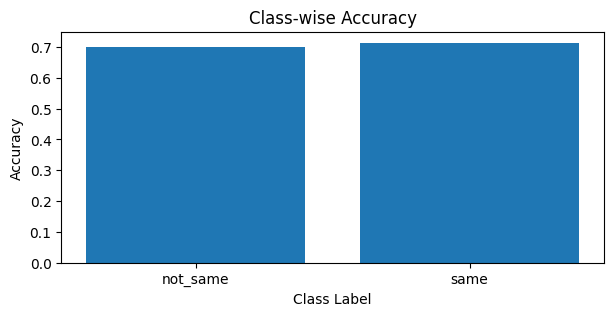

In [56]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

In [57]:
class_labels = ['Not same', 'same']

single_data_point = {
    'question1': "how can i get peace of mind",
    'question1_len': [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    'question2': "what is the way to get peace of mind",
    'question2_len': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]}

question1 = np.array(single_data_point['question1'])
question1_len = np.array(single_data_point['question1_len'])
question2 = np.array(single_data_point['question2'])
question2_len = np.array(single_data_point['question2_len'])

model_inputs = {
    'question1': question1,
    'question1_len': question1_len,
    'question2': question2,
    'question2_len': question2_len}

for key, value in model_inputs.items():
    model_inputs[key] = np.expand_dims(value, axis=0)

predictions = shared_model.predict(model_inputs)
predicted_labels = np.round(predictions)
label = class_labels[int(predicted_labels[0][0])]
print("Predicted Labels:", label)

1/1 [==============================] - 1s 1s/step
Predicted Labels: same


# Combined Model

In [58]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LayerNormalization, Multiply

In [59]:
question1_input_layer = Input(shape=(1, ), dtype=tf.string, name='question1')
question1_text_vectors = vectorize_layer(question1_input_layer)
question1_token_embeddings = token_embed(question1_text_vectors)

q1 = LSTM(16, kernel_regularizer=l2(0.01))(question1_token_embeddings)
q1 = Dropout(0.4)(q1)
q1 = Dense(16, activation='relu')(q1)
q1 = LayerNormalization()(q1)

q1_numwords_input_layer = Input(shape=(24,), dtype=tf.int32, name="question1_len")
q1_len = Dense(16, activation="relu")(q1_numwords_input_layer)
q1 = Concatenate()([q1, q1_len])

question2_input_layer = Input(shape=(1, ), dtype=tf.string, name='question2')
question2_text_vectors = vectorize_layer(question2_input_layer)
question2_token_embeddings = token_embed(question2_text_vectors)
q2 = LSTM(16, kernel_regularizer=l2(0.01))(question2_token_embeddings)
q2 = Dropout(0.6)(q2)
q2 = Dense(16, activation='relu')(q2)
q2 = LayerNormalization()(q2)

q2_numwords_input_layer = Input(shape=(24,), dtype=tf.int32, name="question2_len")
q2_len = Dense(16, activation="relu")(q2_numwords_input_layer)
q2 = Concatenate()([q2, q2_len])

q = Multiply()([q1, q2])
q = Dense(16, activation="relu")(q)
q = BatchNormalization()(q)
output_layer = Dense(1, activation="sigmoid")(q)

combined_model = Model(inputs={'question1': question1_input_layer, 'question1_len': q1_numwords_input_layer,
                      'question2': question2_input_layer, 'question2_len': q2_numwords_input_layer},
                       outputs=output_layer)

combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 question1 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 question2 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 24)                   0         ['question1[0][0]',           
 ctorization)                                                        'question2[0][0]']           
                                                                                                  
 Embeddings (Embedding)      (None, 24, 128)              3840000   ['text_vectorization[2][

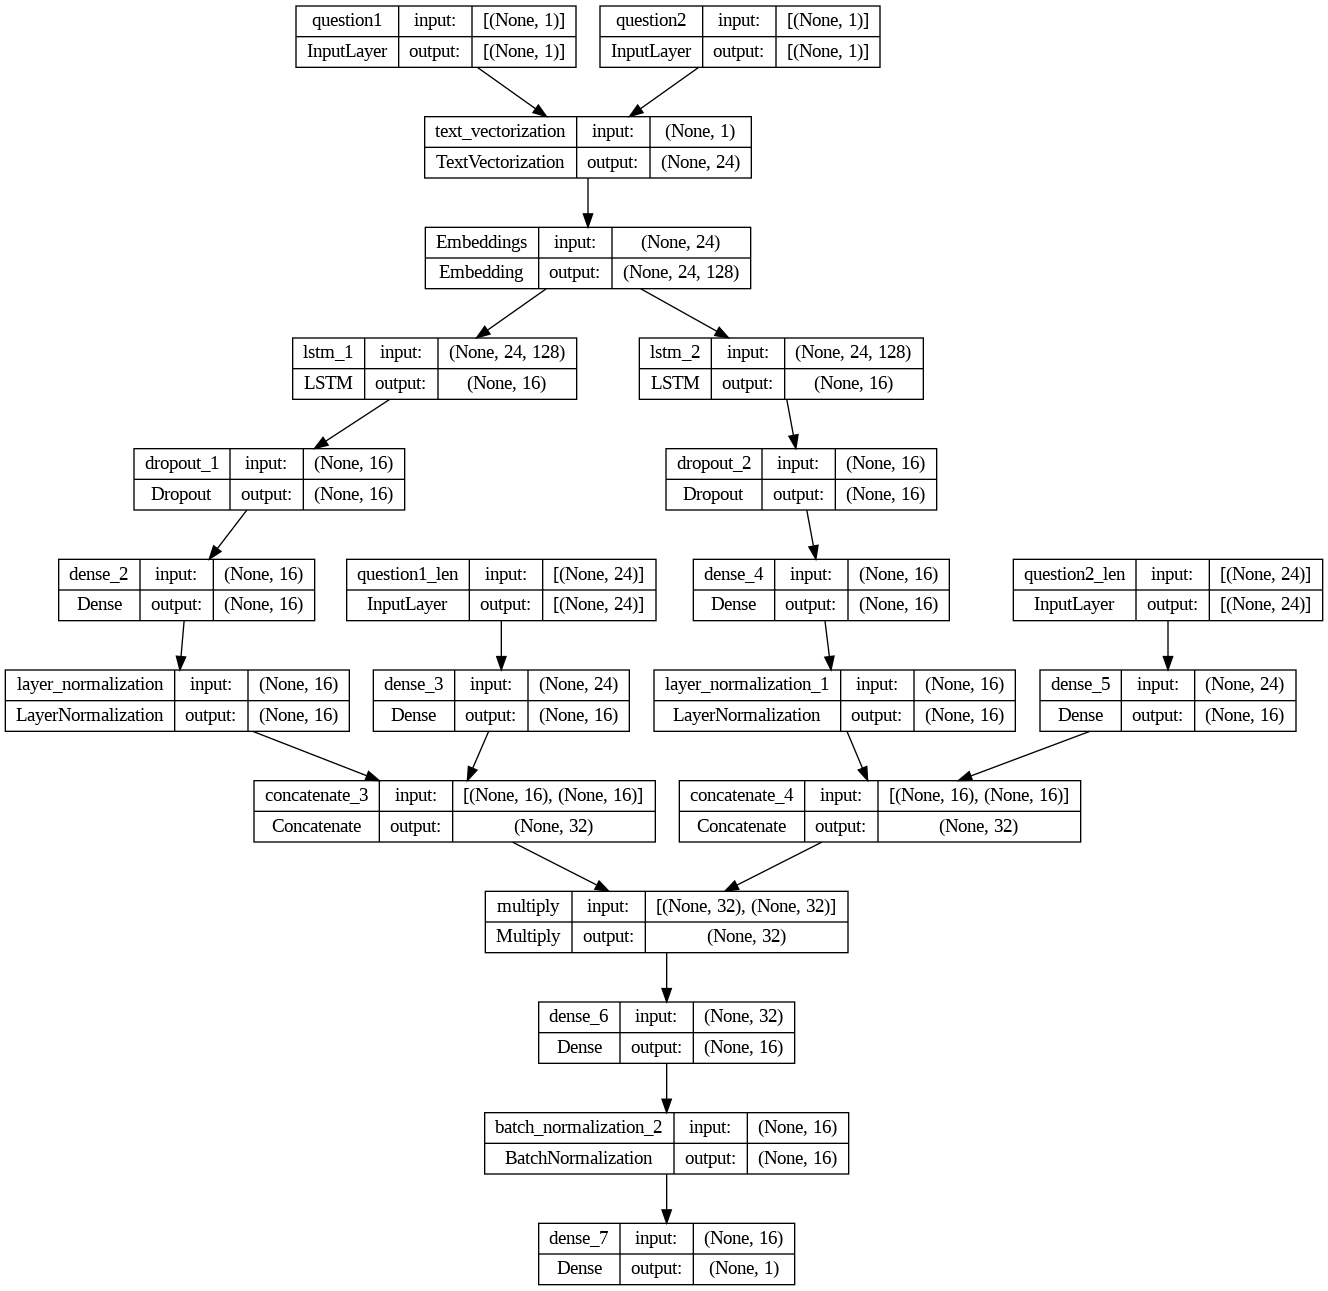

In [60]:
plot_model(combined_model, show_shapes=True)

In [61]:
combined_model.compile(loss=BinaryCrossentropy(),
                      optimizer=Adam(),
                      metrics=[Recall(name='recall')])

In [62]:
history = combined_model.fit(train_dataset,
                          validation_data = test_dataset,
                          callbacks = create_tensorboard_callback("combined_model"),
                          class_weight = weights,
                          epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 55s 37ms/step - loss: 0.9711 - recall: 0.8433 - val_loss: 1.0204 - val_recall: 0.8175
Epoch 2/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4881 - recall: 0.9338 - val_loss: 0.9908 - val_recall: 0.6989
Epoch 3/5
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4026 - recall: 0.9487 - val_loss: 1.0068 - val_recall: 0.6416
Epoch 4/5
1250/1250 [==============================] - 22s 18ms/step - loss: 0.3720 - recall: 0.9522 - val_loss: 1.2195 - val_recall: 0.6382
Epoch 5/5
1250/1250 [==============================] - 20s 16ms/step - loss: 0.3453 - recall: 0.9559 - val_loss: 1.3600 - val_recall: 0.6190


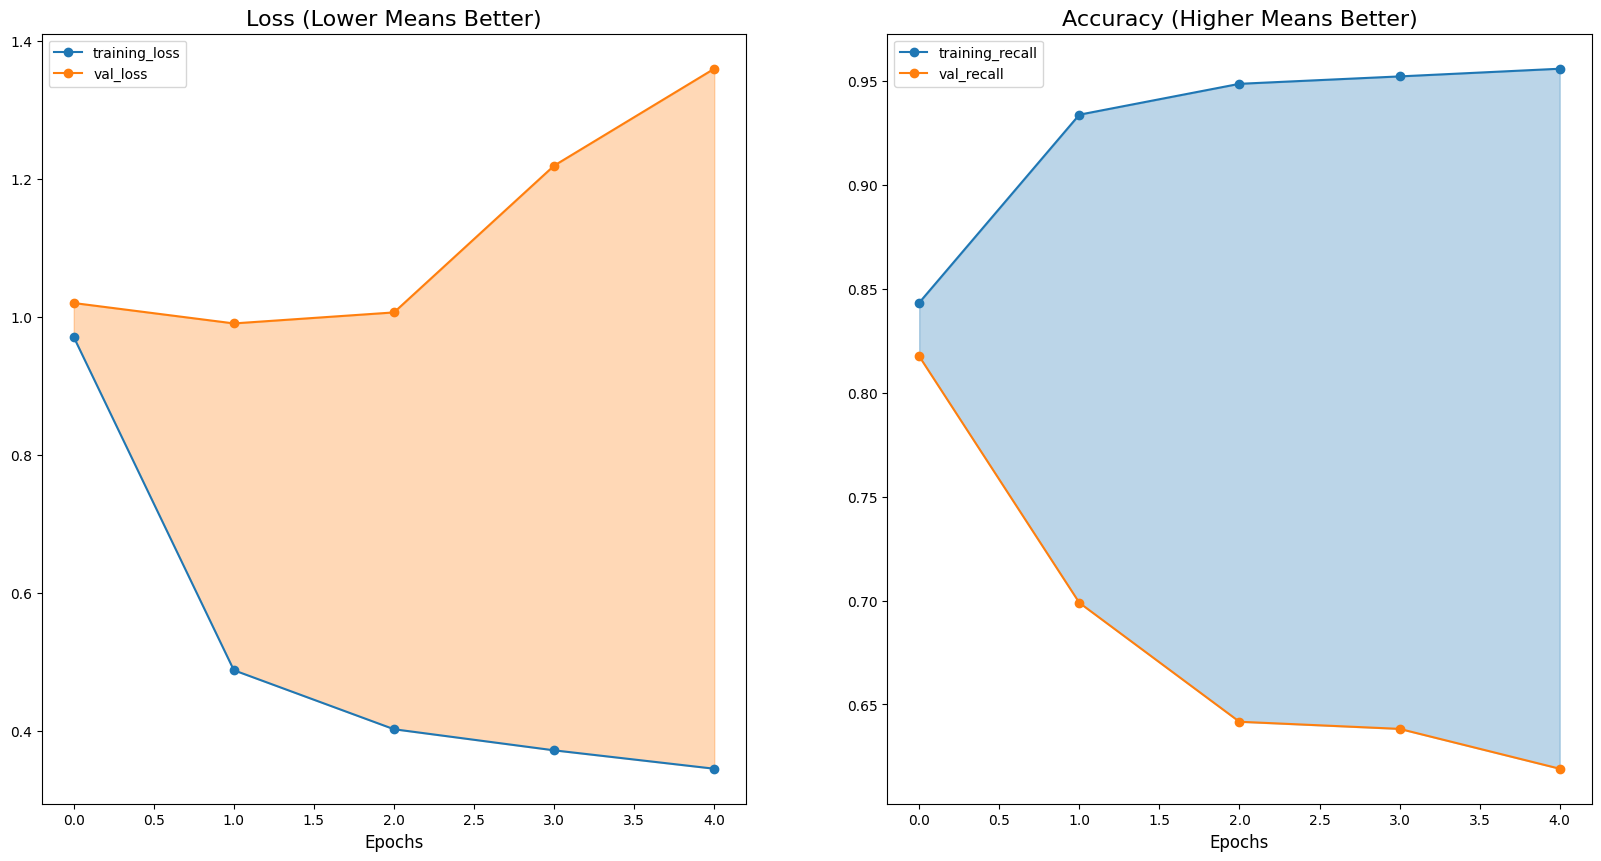

In [63]:
plot_loss_curves(history)

In [64]:
model_pred_probs = combined_model.predict(test_dataset, verbose=1)
model_pred_probs

313/313 [==============================] - 2s 5ms/step


array([[0.98894995],
       [0.0027958 ],
       [0.926689  ],
       ...,
       [0.6598467 ],
       [0.00304333],
       [0.00336273]], dtype=float32)

In [65]:
model_preds = np.round(model_pred_probs)
model_preds[:5]

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [66]:
true_value = np.array(y_test)
predicted_value = np.array(model_preds)

Confusion Matrix


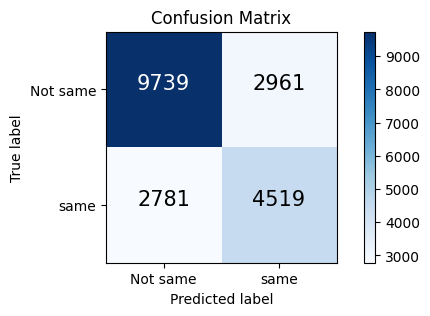

In [67]:
print("Confusion Matrix")
make_confusion_matrix(y_true = true_value,
                      y_pred = predicted_value,
                      classes = class_labels,
                      figsize = (7, 3))

In [68]:
print("Classification Report")
print(classification_report(true_value, predicted_value))

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.77      0.77     12700
           1       0.60      0.62      0.61      7300

    accuracy                           0.71     20000
   macro avg       0.69      0.69      0.69     20000
weighted avg       0.71      0.71      0.71     20000



ClassWise Accuracy


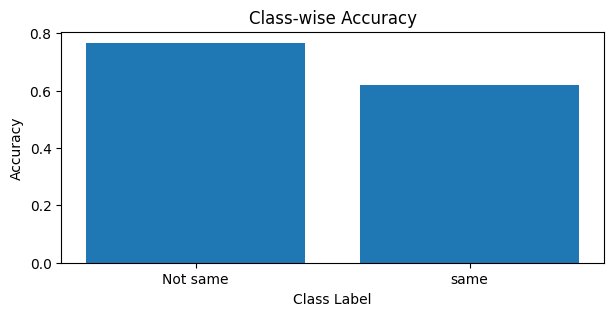

In [69]:
print("ClassWise Accuracy")
plot_class_accuracy(num_classes = 2,
                    y_true = true_value,
                    y_pred = predicted_value,
                    classes = class_labels,
                    figsize = (7, 3))

In [70]:
class_labels = ['Not same', 'same']

single_data_point = {
    'question1': "how can i get peace of mind",
    'question1_len': [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    'question2': "what is the way to get peace of mind",
    'question2_len': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]}

question1 = np.array(single_data_point['question1'])
question1_len = np.array(single_data_point['question1_len'])
question2 = np.array(single_data_point['question2'])
question2_len = np.array(single_data_point['question2_len'])

model_inputs = {
    'question1': question1,
    'question1_len': question1_len,
    'question2': question2,
    'question2_len': question2_len}

for key, value in model_inputs.items():
    model_inputs[key] = np.expand_dims(value, axis=0)

predictions = combined_model.predict(model_inputs)
predicted_labels = np.round(predictions)
label = class_labels[int(predicted_labels[0][0])]
print("Predicted Labels:", label)

1/1 [==============================] - 1s 1s/step
Predicted Labels: same


# Sentence Transformer Model

In [ ]:
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,DataCollatorForTokenClassification,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFRobertaForTokenClassification,TFAutoModelForTokenClassification)

In [ ]:
from datasets import Dataset

In [ ]:
dataset = Dataset.from_pandas(new_df)

In [ ]:
dataset

Dataset({
    features: ['question1', 'question2', 'is_duplicate', '__index_level_0__'],
    num_rows: 99999
})

In [ ]:
dataset[0]

{'question1': 'how can i not get bored in class',
 'question2': 'how do i not get bored in class when i just need to read the book to understand everything',
 'is_duplicate': 1,
 '__index_level_0__': 292635}

In [ ]:
model_id = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
def preprocess(dataset):
  dataset['input_ids_sentence_1'] = []
  dataset['token_type_ids_sentence_1'] = []
  dataset['attention_mask_sentence_1'] = []

  dataset['input_ids_sentence_2'] = []
  dataset['token_type_ids_sentence_2'] = []
  dataset['attention_mask_sentence_2'] = []

  tokenized_sentence_1 = tokenizer(dataset['question1'], max_length=24, padding='max_length', truncation=True)
  tokenized_sentence_2 = tokenizer(dataset['question2'], max_length=24, padding='max_length', truncation=True)

  dataset['input_ids_sentence_1'].append(tokenized_sentence_1['input_ids'])
  dataset['token_type_ids_sentence_1'].append(tokenized_sentence_1['token_type_ids'])
  dataset['attention_mask_sentence_1'].append(tokenized_sentence_1['attention_mask'])

  dataset['input_ids_sentence_2'].append(tokenized_sentence_2['input_ids'])
  dataset['token_type_ids_sentence_2'].append(tokenized_sentence_2['token_type_ids'])
  dataset['attention_mask_sentence_2'].append(tokenized_sentence_2['attention_mask'])

  return dataset

In [ ]:
dataset = dataset.map(preprocess)

Map:   0%|          | 0/99999 [00:00<?, ? examples/s]

In [ ]:
dataset

Dataset({
    features: ['question1', 'question2', 'is_duplicate', '__index_level_0__', 'input_ids_sentence_1', 'token_type_ids_sentence_1', 'attention_mask_sentence_1', 'input_ids_sentence_2', 'token_type_ids_sentence_2', 'attention_mask_sentence_2'],
    num_rows: 99999
})

In [ ]:
train_dataset = dataset.to_tf_dataset(
    columns = ['input_ids_sentence_1', 'token_type_ids_sentence_1', 'attention_mask_sentence_1',
               'input_ids_sentence_2', 'token_type_ids_sentence_2', 'attention_mask_sentence_2',
               'is_duplicate'],
    shuffle = True,
    batch_size = 64
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec={'is_duplicate': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'input_ids_sentence_1': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None), 'token_type_ids_sentence_1': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None), 'attention_mask_sentence_1': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None), 'input_ids_sentence_2': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None), 'token_type_ids_sentence_2': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None), 'attention_mask_sentence_2': TensorSpec(shape=(None, 1, 64), dtype=tf.int64, name=None)}>

## Model

In [ ]:
model_id = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'
model = TFAutoModel.from_pretrained(model_id)
model.summary()

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at sentence-transformers/multi-qa-MiniLM-L6-cos-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  22713216  
                                                                 
Total params: 22713216 (86.64 MB)
Trainable params: 22713216 (86.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


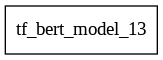

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras import Model

In [ ]:
class SentenceTransformer(tf.keras.Model):
  def __init__(self, model):
    super(SentenceTransformer, self).__init__()
    self.model = model
    self.dense = tf.keras.layers.Dense(1, activation='sigmoid')

  def compile(self, optimizer, loss_fn):
    super(SentenceTransformer, self).compile()
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.loss_metric = tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_metric]

  def mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output[0]

    input_mask_expanded = tf.cast(
        tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),
        tf.float32
    )
    return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)/tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)

  def train_step(self, train_data):
    sentence_1 = {'input_ids': train_data['input_ids_sentence_1'][:, 0, :],
                  'token_type_ids': train_data['token_type_ids_sentence_1'][:, 0, :],
                  'attention_mask': train_data['attention_mask_sentence_1'][:, 0, :]}

    sentence_2 = {'input_ids': train_data['input_ids_sentence_2'][:, 0, :],
                  'token_type_ids': train_data['token_type_ids_sentence_2'][:, 0, :],
                  'attention_mask': train_data['attention_mask_sentence_2'][:, 0, :]}

    labels = train_data['is_duplicate']

    with tf.GradientTape() as recorder:
      sentence_1_prediction = self.model(sentence_1)
      pred_sentence_1 = self.mean_pooling(sentence_1_prediction, train_data['attention_mask_sentence_1'][:, 0, :])

      sentence_2_prediction = self.model(sentence_2)
      pred_sentence_2 = self.mean_pooling(sentence_2_prediction, train_data['attention_mask_sentence_2'][:, 0, :])

      pred_concat = tf.concat([pred_sentence_1, pred_sentence_2, tf.abs(pred_sentence_1 - pred_sentence_2)], axis=-1)
      predictions = self.dense(pred_concat)

      loss = self.loss_fn(labels, predictions)

    partial_derivatives = recorder.gradient(loss, self.model.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.model.trainable_weights))

    self.loss_metric.update_state(loss)

    return {'loss':self.loss_metric.result(),}

In [ ]:
stransformer = SentenceTransformer(model)
stransformer.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss_fn = tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
history = stransformer.fit(train_dataset.take(1),
                           epochs=1)

1/1 [==============================] - 41s 41s/step - loss: 0.6969


In [ ]:
history.history

{'loss': [0.6968534588813782]}

## Model at inference

In [ ]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output[0]
  input_mask_expanded = tf.cast(tf.broadcast_to(tf.expand_dims(attention_mask, -1), tf.shape(token_embeddings)),tf.float32)
  return tf.math.reduce_sum(token_embeddings * input_mask_expanded, axis=1)/tf.clip_by_value(tf.math.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)

In [ ]:
sentence_1 = "newly formed camp is released from the membrane and diffuses across the intracellular space where it serves to activate pka."
sentence_2 = "recently made encampment is released from the membrane and diffuses across the intracellular space where it serves to activate pka."

sentence_1 = tokenizer([sentence_1], max_length=12, padding='max_length', truncation=True, return_tensors="tf")
sentence_2 = tokenizer([sentence_2], max_length=12, padding='max_length', truncation=True, return_tensors="tf")

logits_1 = model(**sentence_1)
output_embedding_1 = mean_pooling(logits_1, sentence_1['attention_mask'])

logits_2 = model(**sentence_2)
output_embedding_2 = mean_pooling(logits_2, sentence_2['attention_mask'])

u_dot_v = np.matmul(np.array(output_embedding_1), np.array(output_embedding_2).T)
u_magnitude = np.sqrt(np.sum(output_embedding_1 * output_embedding_1, axis=-1))
v_magnitude = np.sqrt(np.sum(output_embedding_2 * output_embedding_2, axis=-1))
cosine_similarity = u_dot_v.T/(u_magnitude*v_magnitude)[0]

if cosine_similarity > 0:
  print("Sentences are similar")
else:
  print("Sentences are not similar")

Sentences are similar


# Saving model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [71]:
shared_model.save("News_Similarity_Analysis")

In [72]:
loaded_model = tf.keras.models.load_model("News_Similarity_Analysis")

In [73]:
class_labels = ['Not same', 'same']

single_data_point = {
    'question1': "how can i get peace of mind",
    'question1_len': [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    'question2': "what is the way to get peace of mind",
    'question2_len': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]}

question1 = np.array(single_data_point['question1'])
question1_len = np.array(single_data_point['question1_len'])
question2 = np.array(single_data_point['question2'])
question2_len = np.array(single_data_point['question2_len'])

model_inputs = {
    'question1': question1,
    'question1_len': question1_len,
    'question2': question2,
    'question2_len': question2_len}

for key, value in model_inputs.items():
    model_inputs[key] = np.expand_dims(value, axis=0)

predictions =  loaded_model.predict(model_inputs)
predicted_labels = np.round(predictions)
label = class_labels[int(predicted_labels[0][0])]
print("Predicted Labels:", label)

1/1 [==============================] - 2s 2s/step
Predicted Labels: same


In [ ]:
%cp -av /content/News_Similarity_Checking /content/drive/MyDrive/News_Similarity_Checking

'/content/News_Similarity_Checking' -> '/content/drive/MyDrive/News_Similarity_Checking'
'/content/News_Similarity_Checking/variables' -> '/content/drive/MyDrive/News_Similarity_Checking/variables'
'/content/News_Similarity_Checking/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/News_Similarity_Checking/variables/variables.data-00000-of-00001'
'/content/News_Similarity_Checking/variables/variables.index' -> '/content/drive/MyDrive/News_Similarity_Checking/variables/variables.index'
'/content/News_Similarity_Checking/assets' -> '/content/drive/MyDrive/News_Similarity_Checking/assets'
'/content/News_Similarity_Checking/fingerprint.pb' -> '/content/drive/MyDrive/News_Similarity_Checking/fingerprint.pb'
'/content/News_Similarity_Checking/saved_model.pb' -> '/content/drive/MyDrive/News_Similarity_Checking/saved_model.pb'
'/content/News_Similarity_Checking/keras_metadata.pb' -> '/content/drive/MyDrive/News_Similarity_Checking/keras_metadata.pb'


# Tensorboard

In [ ]:
!kill 21042

In [74]:
%load_ext tensorboard
%tensorboard --logdir /content/logs

<IPython.core.display.Javascript object>

# Hugging Face

In [75]:
! pip install huggingface_hub

In [76]:
from huggingface_hub import notebook_login
notebook_login()

In [78]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = shared_model, repo_id = "DriveMyScream/News_Similarity_Analysis")

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

keras_metadata.pb:   0%|          | 0.00/36.2k [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/2.87M [00:00<?, ?B/s]

'https://huggingface.co/DriveMyScream/News_Similarity_Analysis/tree/main/'

In [79]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/News_Similarity_Analysis")

config.json not found in HuggingFace Hub.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [80]:
class_labels = ['Not same', 'same']

single_data_point = {
    'question1': "how can i get peace of mind",
    'question1_len': [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    'question2': "what is the way to get peace of mind",
    'question2_len': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]}

question1 = np.array(single_data_point['question1'])
question1_len = np.array(single_data_point['question1_len'])
question2 = np.array(single_data_point['question2'])
question2_len = np.array(single_data_point['question2_len'])

model_inputs = {
    'question1': question1,
    'question1_len': question1_len,
    'question2': question2,
    'question2_len': question2_len}

for key, value in model_inputs.items():
    model_inputs[key] = np.expand_dims(value, axis=0)

predictions = loaded_model.predict(model_inputs)
predicted_labels = np.round(predictions)
label = class_labels[int(predicted_labels[0][0])]
print("Predicted Labels:", label)

1/1 [==============================] - 1s 1s/step
Predicted Labels: same


# Tensorflow Lite

In [81]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(shared_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "News_Similarity_Checking.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="News_Similarity_Checking.tflite")
interpreter.allocate_tensors()

# Get input and output details from the interpreter
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

class_labels = ['Not same', 'same']

single_data_point = {
    'question1': "how can i get peace of mind",
    'question1_len': [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    'question2': "what is the way to get peace of mind",
    'question2_len': [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
}

# Prepare the input tensors
question1 = np.array(single_data_point['question1'], dtype=np.int32)
question1_len = np.array(single_data_point['question1_len'], dtype=np.int32)
question2 = np.array(single_data_point['question2'], dtype=np.int32)
question2_len = np.array(single_data_point['question2_len'], dtype=np.int32)

# Set the input tensors in the interpreter
interpreter.set_tensor(input_details[0]['index'], question1)
interpreter.set_tensor(input_details[1]['index'], question2)
interpreter.set_tensor(input_details[2]['index'], question1_len)
interpreter.set_tensor(input_details[3]['index'], question2_len)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Round the output to obtain binary labels (0 or 1)
predicted_labels = np.round(output_data)

# Map the predicted label to class labels
label = class_labels[int(predicted_labels[0][0])]
print("Predicted Labels:", label)

# Helper Function

In [47]:
def plot_loss_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['recall'])
    val_accuracy = np.array(history.history['val_recall'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_recall', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_recall', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();